In [5]:
## Madison Christiansen
## DSC530 Week 5

## Exercise 5.1

In [6]:
## **Exercise:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

## In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

In [7]:
import scipy.stats

In [8]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

scipy.stats._distn_infrastructure.rv_continuous_frozen

In [9]:
dist.mean(), dist.std()

(178.0, 7.7)

In [10]:
dist.cdf(mu - sigma)

0.1586552539314574

In [11]:
## How many people are between 5'10" and 6'1"?

In [12]:
low = dist.cdf(177.8)
high = dist.cdf(185.4)
high-low

0.3420946829459531

In [ ]:
## Exercise 5.2

In [13]:
## **Exercise:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

## Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

# `scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [14]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

1.5034066538560549

In [ ]:
## What is the mean height in Pareto world?

In [15]:
dist.mean()

2.428571428571429

In [ ]:
## What fraction of people are shorter than the mean?

In [20]:
dist.cdf(dist.mean())

0.778739697565288

In [16]:
## Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

In [17]:
(1 - dist.cdf(1000)) * 7e9 
dist.sf(1000) * 7e9

55602.97643069972

In [18]:
## How tall do we expect the tallest person to be?

In [19]:
dist.sf(600000)*7e9

1.0525455861201714

In [ ]:
## Exercise 6.1

In [38]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [39]:
import numpy as np

import thinkstats2
import thinkplot

In [40]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [41]:
import brfss

df = brfss.ReadBrfss(nrows=None)

In [54]:
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

In [55]:
def Mean(xs):
    return RawMoment(xs, 1)

In [85]:
def CentralMoment(xs, k):
    mean = RawMoment(xs, 1)
    return sum((x - mean)**k for x in xs) / len(xs)

In [70]:
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    return CentralMoment(xs, k) / std**k

In [71]:
def Skewness(xs):
    return StandardizedMoment(xs, 3)

In [72]:
def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)

In [73]:
def PearsonMedianSkewness(xs):
    median = Median(xs)
    mean = RawMoment(xs, 1)
    var = CentralMoment(xs, 2)
    std = np.sqrt(var)
    gp = 3 * (mean - median) / std
    return gp

In [74]:
## The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
## The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

## The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

## To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

## It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

## `InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [75]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample

In [76]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [77]:
import hinc
income_df = hinc.ReadData()

In [78]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

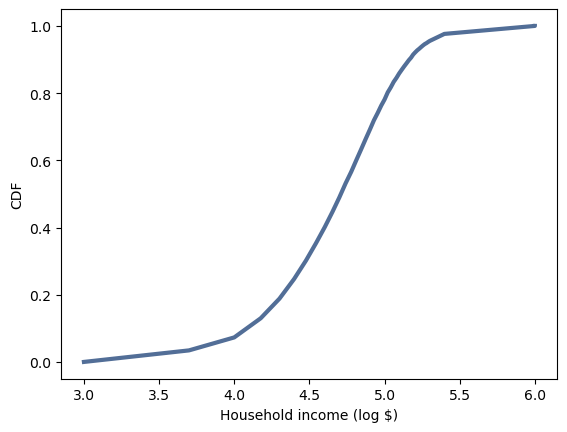

In [79]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [80]:
sample = np.power(10, log_sample)

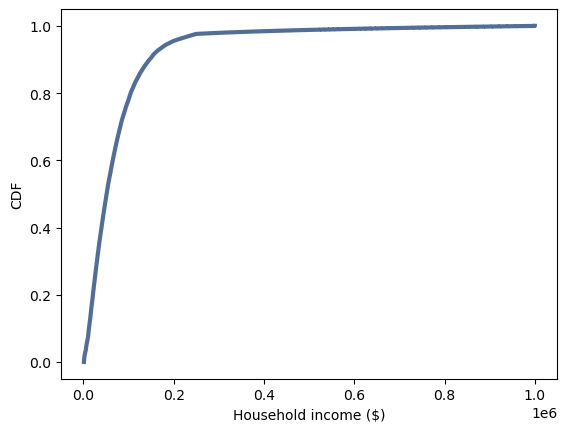

In [81]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

In [82]:
## Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [83]:
Mean(sample), Median(sample)

(74278.70753118733, 51226.45447894046)

In [86]:
Skewness(sample), PearsonMedianSkewness(sample)

(4.949920244429583, 0.7361258019141782)

In [69]:
cdf.Prob(Mean(sample))

0.660005879566872